In [1]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-a4a538a2-a199-58d8-9e56-ed86db02edf8"

In [2]:
import sys
print(sys.executable)

/home/sahsan/PythonProjects/pytorch/Falcon-7B/manual_py_3_8_env/bin/python


In [3]:
import torch
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import warnings
warnings.filterwarnings("ignore")

In [5]:
from huggingface_hub import notebook_login
notebook_login()

# Load the Pre-trained Model

In [6]:
model_name = "tiiuae/falcon-7b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,            # load model in 4-bit precision
    bnb_4bit_quant_type="nf4",    # pre-trained model should be quantized in 4-bit NF format
    # bnb_4bit_use_double_quant=True, # Using double quantization as mentioned in QLoRA paper
    bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=torch.bfloat16, # During computation, pre-trained model should be loaded in BF16 format
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # Use bitsandbytes config
    device_map="auto",  # Specifying device_map="auto" so that HF Accelerate will determine which GPU to put each layer of the model on
    trust_remote_code=True, # Set trust_remote_code=True to use falcon-7b
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) # Set trust_remote_code=True
tokenizer.pad_token = tokenizer.eos_token # Setting pad_token same as eos_token

Setting up Inference

In [8]:
# Given my model is fine-tuned to generate answers directly from questions without needing an external context I used a text-generation pipeline for inference. This type of pipeline is well-suited for models that have been trained in a conversational or question-answer format where the model generates an answer based solely on the input question.

from transformers import (
    pipeline,
    logging
)

logging.set_verbosity(logging.CRITICAL)

In [9]:
def extract_after_first_line(text):
    parts = text.split("\n")
    remaining_text = "\n".join(parts[1:])
    return remaining_text

In [10]:
prompt = "Where can I find detailed information about the security vulnerability CVE-2022-37326?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=256)
result = pipe(f"{prompt}\n")
model_answer = result[0]['generated_text']
print(model_answer)

Where can I find detailed information about the security vulnerability CVE-2022-37326?
The vulnerability CVE-2022-37326 is a remote code execution vulnerability in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
A remote attacker can exploit this vulnerability to execute arbitrary code in the context of the SYSTEM user.
The vulnerability is rated as critical.
The following versions are affected:
- Microsoft Exchange Server 2013 Service Pack 2
- Microsoft Exchange Server 2016 Service Pack 3
- Microsoft Exchange Server 2019 Service Pack 1
- Microsoft Exchange Server 2019 Service Pack 2
- Microsoft Exchange Server 2019 Service Pack 3
- Microsoft Exchange Server 2019 Service Pack 4
- Microsoft Exchange Server 2019 Service Pack 5
- Microsoft Exchange Server 2019 Service Pack 6
- Microsoft Exchange Server 2019 Service Pack 7
- Microsoft Exchange Server 2019 Service Pack 8
- Microsoft Exchange Server 2019 Service Pack 9
- Micro

In [11]:
first_response = extract_after_first_line(model_answer)
# print("First Assistant Response:\n", first_response)
print(first_response)

The vulnerability CVE-2022-37326 is a remote code execution vulnerability in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
A remote attacker can exploit this vulnerability to execute arbitrary code in the context of the SYSTEM user.
The vulnerability is rated as critical.
The following versions are affected:
- Microsoft Exchange Server 2013 Service Pack 2
- Microsoft Exchange Server 2016 Service Pack 3
- Microsoft Exchange Server 2019 Service Pack 1
- Microsoft Exchange Server 2019 Service Pack 2
- Microsoft Exchange Server 2019 Service Pack 3
- Microsoft Exchange Server 2019 Service Pack 4
- Microsoft Exchange Server 2019 Service Pack 5
- Microsoft Exchange Server 2019 Service Pack 6
- Microsoft Exchange Server 2019 Service Pack 7
- Microsoft Exchange Server 2019 Service Pack 8
- Microsoft Exchange Server 2019 Service Pack 9
- Microsoft Exchange Server 2019 Service Pack 10
- Microsoft Exchange Server 2019 Service Pack

Answer each question from the validation set

In [ ]:
import json
from transformers import pipeline

with open('rephrased_data.json', 'r') as file:
    data = json.load(file)

def generate_answer(text):
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=256)
    result = pipe(f"{text}\n")
    return extract_after_first_line(result[0]['generated_text'])

# Open the output file
with open('model_rephrased_data.json', 'w') as outfile:
    outfile.write("[\n")  # Start of JSON array

    for i, item in enumerate(data):
        prompt = item['question']
        generated_answer = generate_answer(prompt)

        new_item = {
            "Question": item['question'],
            "Model Answer": generated_answer,
            "True Answer": item['answer']
        }

        json.dump(new_item, outfile, indent=4)

        # Add a comma and newline after each new item except the last
        if i < len(data) - 1:
            outfile.write(",\n")

        # Print statements after processing each item
        print(f"Item {i+1}:")
        print(f"Question: {item['question']}")
        print(f"Original Answer: {item['answer']}")
        print(f"Generated Answer: {generated_answer}")
        print("\n")

        outfile.flush()

    outfile.write("\n]")

print("New JSON file created with generated answers.")


# Generated Answers Distribution

In [3]:
import json

# Read the JSON file
try:
    with open('Further Json Outputs/model_rephrased_data.json', 'r', encoding='utf-8') as file:
        data = json.load(file)

    max_len_question = max_len_model_answer = max_len_true_answer = 0
    total_len_question = total_len_model_answer = total_len_true_answer = 0
    count = len(data)

    # Iterate through each item in the data
    for item in data:
        question_len = len(item.get("Question", ""))
        model_answer_len = len(item.get("Model Answer", ""))
        true_answer_len = len(item.get("True Answer", ""))

        # Update maximum lengths
        max_len_question = max(max_len_question, question_len)
        max_len_model_answer = max(max_len_model_answer, model_answer_len)
        max_len_true_answer = max(max_len_true_answer, true_answer_len)

        # Sum up total lengths
        total_len_question += question_len
        total_len_model_answer += model_answer_len
        total_len_true_answer += true_answer_len

    # Calculate the average lengths
    avg_len_question = total_len_question / count
    avg_len_model_answer = total_len_model_answer / count
    avg_len_true_answer = total_len_true_answer / count

    # Calculate the average number of tokens (assuming 1 token = 4 chars)
    avg_tokens_question = avg_len_question / 4
    avg_tokens_model_answer = avg_len_model_answer / 4
    avg_tokens_true_answer = avg_len_true_answer / 4

    # Print the maximum lengths and the calculated tokens
    print("Maximum length of 'Question':", max_len_question, "(", max_len_question // 4, "tokens)")
    print("Maximum length of 'Model Answer':", max_len_model_answer, "(", max_len_model_answer // 4, "tokens)")
    print("Maximum length of 'True Answer':", max_len_true_answer, "(", max_len_true_answer // 4, "tokens)")

    # Print the average number of tokens for each key
    print("\nAverage number of tokens for 'Question':", round(avg_tokens_question, 2))
    print("Average number of tokens for 'Model Answer':", round(avg_tokens_model_answer, 2))
    print("Average number of tokens for 'True Answer':", round(avg_tokens_true_answer, 2))

except Exception as e:
    print(f"An error occurred: {e}")


Maximum length of 'Question': 264 ( 66 tokens)
Maximum length of 'Model Answer': 3042 ( 760 tokens)
Maximum length of 'True Answer': 1349 ( 337 tokens)

Average number of tokens for 'Question': 19.81
Average number of tokens for 'Model Answer': 435.87
Average number of tokens for 'True Answer': 75.59


# Pass Answers to GPT Pipeline

In [24]:
# %pip install openai
# %pip install python-dotenv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [5]:
from dotenv import load_dotenv
from openai import OpenAI
import time
import os

load_dotenv()

def check_answer_with_gpt3(question, model_answer, true_answer):
  client = OpenAI(api_key=os.getenv("API_KEY"))

  # # Ensure the model answer is not longer than 1000 characters
  # if len(model_answer) > 1000:
  #   model_answer = model_answer[:1000] + " [Truncated]"

  prompt = f'''
    "Question": "{question}",
    "Model Answer": "{model_answer}",
    "True Answer": "{true_answer}"
  '''

  thread = client.beta.threads.create()
  message = client.beta.threads.messages.create(
      thread_id=thread.id,
      role="user",
      content=f"{prompt}"
  )

  run = client.beta.threads.runs.create(
    thread_id = thread.id,
    assistant_id = os.getenv("MODEL_ASSISTANT_ID"),
  )

  while run.status != 'completed':
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    # print(run.status)
    time.sleep(5)

  thread_messages = client.beta.threads.messages.list(thread.id)
  response_text = thread_messages.data[0].content[0].text.value
  return response_text

In [ ]:
import json
import threading
import time
from openai import OpenAI

def parse_gpt_response(response):
    # Initialize default values
    parsed_response = {
        'GPT-3 Validation': None,
        'Confidence Percentage': None,
        'Asked for Code in Question': None,
        'Code in Answer': None
    }

    segments = response.split(":")
    
    if len(segments) >= 4:
        # Extracting values after each colon
        parsed_response['GPT-3 Validation'] = segments[1].split()[0]
        parsed_response['Confidence Percentage'] = segments[2].split()[0]
        parsed_response['Asked for Code in Question'] = segments[3].split()[0]
        parsed_response['Code in Answer'] = segments[4].split()[0] if len(segments) > 4 else None

    return parsed_response

def get_gpt3_response(question, model_answer, true_answer, response_container):
    # Placeholder for GPT-3 interaction function
    response_container["response"] = check_answer_with_gpt3(question, model_answer, true_answer)

def main():
    input_filename = "Further Json Outputs/model_rephrased_data.json"
    output_filename = "Further Json Outputs/valued_rephrased_data.json"

    # Variables to control the start and finish of processing
    start = 0
    finish = -1 

    with open(input_filename, 'r') as file:
        data = json.load(file)

    # Check if the output file already starts with '['
    try:
        with open(output_filename, 'r') as outfile:
            first_char = outfile.read(1)
            first_item = first_char != '['
    except FileNotFoundError:
        first_item = True

    # Adjust range of processing based on start and finish
    if finish == -1 or finish > len(data):
        finish = len(data)

    for index in range(start, finish):
        item = data[index]
        print(f"Processing item {index}")

        question = item['Question'].strip()
        model_answer = item['Model Answer'].strip()
        true_answer = item['True Answer'].strip()

        gpt3_response_container = {"response": None}

        # Start thread for GPT-3 response
        response_thread = threading.Thread(target=get_gpt3_response, args=(question, model_answer, true_answer, gpt3_response_container))
        response_thread.start()
        response_thread.join(timeout=15)  # 15-second timeout

        # Initialize parsed_response
        parsed_response = {
            'GPT-3 Validation': None,
            'Confidence Percentage': None,
            'Asked for Code in Question': None,
            'Code in Answer': None
        }

        if gpt3_response_container["response"] is None:
            print("GPT-3 response timed out")
            parsed_response = {key: 'Not Available' for key in parsed_response.keys()}
        else:
            parsed_response = parse_gpt_response(gpt3_response_container["response"])

        item.update(parsed_response)

        # Write to the JSON file
        with open(output_filename, 'a') as outfile:
            if first_item:
                outfile.write('[' if not first_char == '[' else '')
                first_item = False
            else:
                outfile.write(',')
            json.dump(item, outfile, indent=4)
        
        time.sleep(2)

    # Close the JSON array in the file
    with open(output_filename, 'a') as outfile:
        outfile.write(']')

if __name__ == "__main__":
    main()


# Data Analysis

In [34]:
import json

# Function to validate and adjust the confidence percentage
def adjust_confidence_percentage(value):
    try:
        num = int(value)
        if num > 100:
            return 100
        elif num < 0:
            return 0
        else:
            return num
    except (ValueError, TypeError):
        # If conversion fails or value is None, treat it as 0
        return 0

# Function to validate "Yes" or "No" answers, treating others as "Not Available"
def validate_yes_no(value):
    if value == "Yes" or value == "No":
        return value
    else:
        return "Not Available"

# Open and read the file
file_path = "Further Json Outputs/valued_rephrased_data.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# Variables to keep track of statistics
gpt3_validation_1_count = 0
gpt3_validation_0_count = 0
yes_yes_count = 0
yes_no_count = 0
no_yes_count = 0
no_no_count = 0
not_available_count = 0 

# SAdjust logic for "GPT-3 Validation" and calculate statistics
for item in data:
    # Adjust "Confidence Percentage" and check if it's >= 50
    adjusted_confidence_percentage = adjust_confidence_percentage(item["Confidence Percentage"])
    
    if adjusted_confidence_percentage >= 50:
        adjusted_gpt3_validation = "1"
    else:
        adjusted_gpt3_validation = "0"
    
    if adjusted_gpt3_validation == "1":
        gpt3_validation_1_count += 1
    elif adjusted_gpt3_validation == "0":
        gpt3_validation_0_count += 1
    
    asked_for_code = validate_yes_no(item["Asked for Code in Question"])
    code_in_answer = validate_yes_no(item["Code in Answer"])
    
    if asked_for_code == "Yes" and code_in_answer == "Yes":
        yes_yes_count += 1
    elif asked_for_code == "Yes" and code_in_answer == "No":
        yes_no_count += 1
    elif asked_for_code == "No" and code_in_answer == "Yes":
        no_yes_count += 1
    elif asked_for_code == "No" and code_in_answer == "No":
        no_no_count += 1
    else:
        not_available_count += 1 

# Print the statistics
print(f'Items with "GPT-3 Validation" set to 1: {gpt3_validation_1_count}')
print(f'Items with "GPT-3 Validation" set to 0: {gpt3_validation_0_count}')
print(f'Items with both "Yes" in "Asked for Code in Question" and "Code in Answer": {yes_yes_count}')
print(f'Items with "Yes" in "Asked for Code in Question" and "No" in "Code in Answer": {yes_no_count}')
print(f'Items with "No" in "Asked for Code in Question" and "Yes" in "Code in Answer": {no_yes_count}')
print(f'Items with both "No" in "Asked for Code in Question" and "Code in Answer": {no_no_count}')
print(f'Items with "Not Available" status in either "Asked for Code in Question" or "Code in Answer": {not_available_count}')


Items with "GPT-3 Validation" set to 1: 898
Items with "GPT-3 Validation" set to 0: 2926
Items with both "Yes" in "Asked for Code in Question" and "Code in Answer": 27
Items with "Yes" in "Asked for Code in Question" and "No" in "Code in Answer": 101
Items with "No" in "Asked for Code in Question" and "Yes" in "Code in Answer": 4
Items with both "No" in "Asked for Code in Question" and "Code in Answer": 3690
Items with "Not Available" status in either "Asked for Code in Question" or "Code in Answer": 2


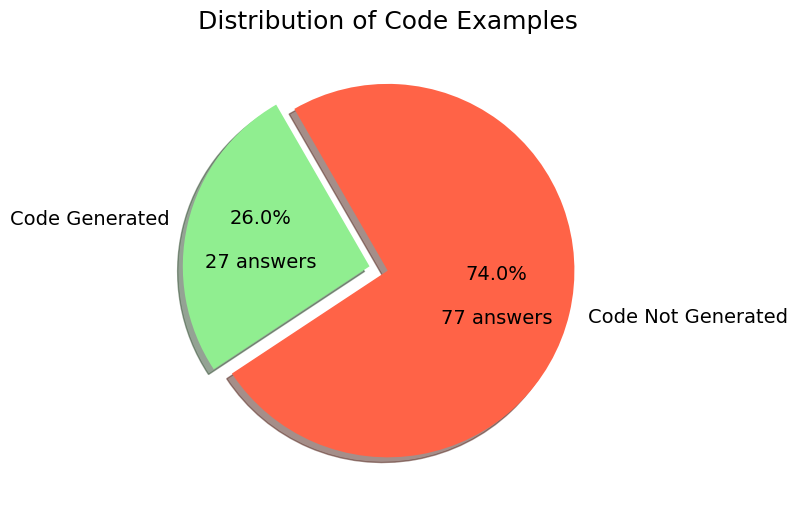

In [35]:
import matplotlib.pyplot as plt

# Increase font sizes globally
plt.rcParams.update({'font.size': 14,  
                     'axes.titlesize': 18,  
                     'axes.labelsize': 16,  
                     'xtick.labelsize': 14,  
                     'ytick.labelsize': 14,  
                     'legend.fontsize': 14}) 

# Data for the pie chart
sizes_asked_yes = [yes_yes_count, (104-yes_yes_count)]
labels_asked_yes = ['Code Generated', 'Code Not Generated']

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%\n\n{v:d} answers'.format(p=pct, v=val)
    return my_format

plt.figure(figsize=(8, 8))
explode = (0.1, 0)
plt.pie(sizes_asked_yes, labels=labels_asked_yes, autopct=autopct_format(sizes_asked_yes), startangle=120, colors=['lightgreen', 'tomato'], explode=explode, shadow=True, textprops={'fontsize': 14})
plt.title('Distribution of Code Examples', fontweight='normal')
plt.tight_layout()
plt.show()


In [36]:
import json

file_path = "Further Json Outputs/valued_rephrased_data.json"

with open(file_path, 'r') as file:
    data = json.load(file)

total_confidence_percentage = 0
count_valid_percentages = 0

for item in data:
    adjusted_percentage = adjust_confidence_percentage(item["Confidence Percentage"])
    total_confidence_percentage += adjusted_percentage
    count_valid_percentages += 1 

average_confidence_percentage = (total_confidence_percentage / count_valid_percentages) if count_valid_percentages > 0 else 0

# Print the average "Confidence Percentage"
print(f'Average "Confidence Percentage" across the dataset: {average_confidence_percentage:.2f}%')

Average "Confidence Percentage" across the dataset: 23.88%


In [37]:
import numpy as np

confidence_percentages = [adjust_confidence_percentage(item["Confidence Percentage"]) for item in data]

# Calculate percentiles
low_threshold = np.percentile(confidence_percentages, 25)
medium_threshold = np.percentile(confidence_percentages, 50)  # This is essentially the median
high_threshold = np.percentile(confidence_percentages, 75)

low_count = len([x for x in confidence_percentages if x <= low_threshold])
medium_count = len([x for x in confidence_percentages if low_threshold < x <= medium_threshold])
high_count = len([x for x in confidence_percentages if x > medium_threshold])  # This includes values above the high_threshold

# Print the thresholds and counts
print(f'Low Threshold (25th percentile): {low_threshold}%')
print(f'Medium Threshold (50th percentile, Median): {medium_threshold}%')
print(f'High Threshold (75th percentile): {high_threshold}%')
print(f'Count of Low "Confidence Percentage": {low_count}')
print(f'Count of Medium "Confidence Percentage": {medium_count}')
print(f'Count of High "Confidence Percentage": {high_count}')

Low Threshold (25th percentile): 0.0%
Medium Threshold (50th percentile, Median): 0.0%
High Threshold (75th percentile): 40.0%
Count of Low "Confidence Percentage": 2104
Count of Medium "Confidence Percentage": 0
Count of High "Confidence Percentage": 1720


In [38]:
import numpy as np

# Calculate histogram bins and counts
bin_edges = np.linspace(0, 100, 11)  # Define 10 bins from 0 to 100
hist_counts, _ = np.histogram(confidence_percentages, bins=bin_edges)

for i in range(len(bin_edges)-1):
    print(f'Confidence Percentage {bin_edges[i]:.0f}% to {bin_edges[i+1]:.0f}%: {hist_counts[i]} answers')


Confidence Percentage 0% to 10%: 2172 answers
Confidence Percentage 10% to 20%: 307 answers
Confidence Percentage 20% to 30%: 253 answers
Confidence Percentage 30% to 40%: 112 answers
Confidence Percentage 40% to 50%: 82 answers
Confidence Percentage 50% to 60%: 122 answers
Confidence Percentage 60% to 70%: 71 answers
Confidence Percentage 70% to 80%: 81 answers
Confidence Percentage 80% to 90%: 117 answers
Confidence Percentage 90% to 100%: 507 answers


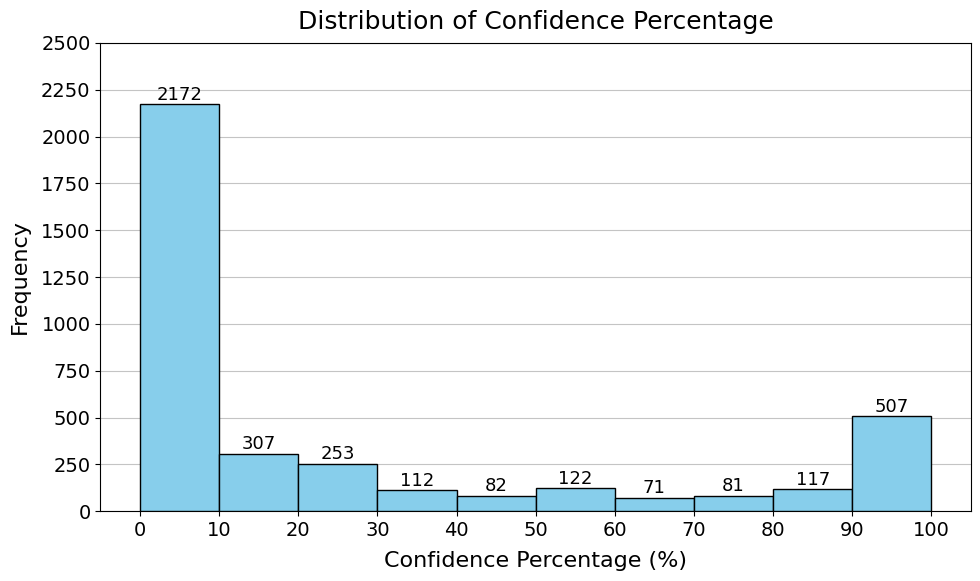

In [39]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 13,  
                     'axes.titlesize': 18,  
                     'axes.labelsize': 16,  
                     'xtick.labelsize': 14, 
                     'ytick.labelsize': 14, 
                     'legend.fontsize': 14})
                     

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(confidence_percentages, bins=10, color='skyblue', edgecolor='black', alpha=1 ,zorder=3)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

spacing = 25  

for count, x in zip(n, bin_centers):
    if count > 0:
        plt.text(x, count + spacing, str(int(count)), ha='center')

plt.title('Distribution of Confidence Percentage', fontweight='normal', pad=10)
plt.xlabel('Confidence Percentage (%)', labelpad=8)
plt.ylabel('Frequency', labelpad=8)
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, max(2750, max(n) + 100), max(250, (max(n) + 100)//10)))

plt.grid(axis='y', alpha=0.75, zorder=0)
plt.tight_layout()
plt.show()


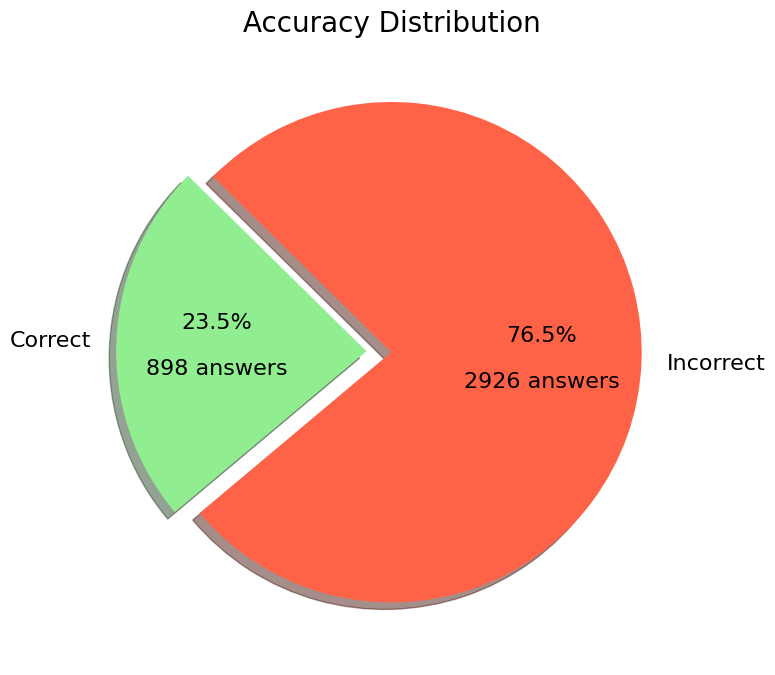

In [40]:
import matplotlib.pyplot as plt


plt.rcParams.update({'font.size': 16,  
                     'axes.titlesize': 20, 
                     'axes.labelsize': 18,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,  
                     'legend.fontsize': 14})

# Data for plotting
gpt3_validation_counts = [gpt3_validation_0_count, gpt3_validation_1_count]
gpt3_labels = ['Incorrect', 'Correct'] 

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%\n\n{v:d} answers'.format(p=pct, v=val)
    return my_format

plt.figure(figsize=(8, 8))
explode = (0, 0.1) 
plt.pie(gpt3_validation_counts, labels=gpt3_labels, autopct=autopct_format(gpt3_validation_counts), startangle=220, colors=['tomato', 'lightgreen'], explode=explode, shadow=True, textprops={'fontsize': 16})
plt.title('Accuracy Distribution', fontweight='normal')
plt.tight_layout()
plt.show()
